In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from annoy import AnnoyIndex
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt

In [3]:
# Load and process customer data:
# initial_data_prep_and_image_retrieval

In [18]:
user = pd.read_pickle("user_dataframe_reduced.pkl")

In [5]:
# Prepare cosine similarity matrix for dimension reduction in PCA
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(user['item'])
print(vectorizer.get_feature_names()[0:100])

# Output the shape of matrix
print(X.shape)

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(X)

print(cosine_sim.shape)

['1000978', '1002098', '1002099', '1002101', '1002102', '1002266', '1002367', '1002482', '1002524', '1002528', '1002532', '1002536', '1002540', '1002542', '1002544', '1002547', '1002548', '1002628', '1002629', '1002633', '1002634', '1002876', '1002929', '1002974', '1003013', '1003050', '1003112', '1003141', '1003153', '1003176', '1003208', '1003222', '1003234', '1003281', '1003285', '1003293', '1003304', '1003305', '1003306', '1003307', '1003310', '1003311', '1003312', '1003313', '1003315', '1003316', '1003317', '1003318', '1003319', '1003339', '1003363', '1003461', '1003523', '1003525', '1003527', '1003533', '1003535', '1003549', '1003566', '1003571', '1003609', '1003613', '1003614', '1003652', '1003656', '1003673', '1003709', '1003712', '1003726', '1003746', '1003755', '1003768', '1003769', '1003798', '1003800', '1003811', '1003855', '1003856', '1003879', '1003883', '1003894', '1003901', '1003906', '1003911', '1003921', '1003951', '1003965', '1003973', '1003981', '1003991', '1004015'

In [6]:
# Prepare for PCA

# Standardize values from cosine similarity matrix
X_std = StandardScaler().fit_transform(cosine_sim)

# Covariance matrix
cov_mat = np.cov(X_std.T)

# Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [7]:
# Principal Component Analysis (PCA) to reduce dimensionality 

pca = PCA(n_components=1000)
pca.fit_transform(cosine_sim)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[1.52554179e-01 1.03804040e-01 7.37056404e-02 2.95491648e-02
 2.91751276e-02 2.84522679e-02 2.44015649e-02 2.01946825e-02
 1.91668585e-02 1.75256518e-02 1.62960181e-02 1.49802602e-02
 1.38007285e-02 1.31552387e-02 1.25850265e-02 1.10288264e-02
 1.09738858e-02 9.67710080e-03 9.28983572e-03 8.80580152e-03
 7.32192132e-03 7.05540541e-03 6.83465647e-03 6.06687530e-03
 6.01061385e-03 5.76262973e-03 5.73185126e-03 5.66643390e-03
 5.38126316e-03 5.18123486e-03 4.98594659e-03 4.89684517e-03
 3.97843201e-03 3.63445747e-03 3.50389740e-03 3.43083801e-03
 3.39645846e-03 3.35566445e-03 3.11337572e-03 3.09461943e-03
 2.75808967e-03 2.63098411e-03 2.60849768e-03 2.45009119e-03
 2.37927453e-03 2.37598955e-03 2.36255784e-03 2.33773077e-03
 2.23515691e-03 2.20767297e-03 2.12498743e-03 2.04740503e-03
 2.04206481e-03 1.76402499e-03 1.71485135e-03 1.67449978e-03
 1.66471680e-03 1.60738402e-03 1.59762136e-03 1.58248530e-03
 1.55522566e-03 1.50868339e-03 1.50393397e-03 1.44339085e-03
 1.33018865e-03 1.303936

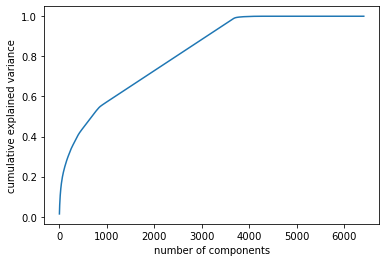

In [8]:
# Explained variance
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [11]:
# Prep final model
pca = PCA(n_components=1000)
pca_output = pca.fit_transform(X_std)
pca_output.shape

(6411, 1000)

In [12]:
# Use pca_output as input to annoy
f = pca_output.shape[1]
t = AnnoyIndex(f, 'angular')
for i in range(pca_output.shape[0]):
    v = pca_output[i]
    t.add_item(i, v)
    
t.build(20) # 10 trees
t.save('user_similarity.ann')

u = AnnoyIndex(f, 'angular')
u.load('user_similarity.ann')

True

In [13]:
print(u.get_nns_by_item(0, 10, include_distances=True))

([0, 1977, 4462, 2797, 4375, 4619, 40, 2937, 4761, 5226], [0.0, 1.2821025848388672, 1.284610629081726, 1.2862889766693115, 1.2873340845108032, 1.2874997854232788, 1.288514494895935, 1.294763207435608, 1.2951562404632568, 1.296054720878601])


In [14]:
def annoy_sim_users(user_id, count=10, search_k=-1):
    
    # Load annoy index
    u = AnnoyIndex(f, 'angular')
    u.load('user_similarity.ann')
    
    # Get the index of the product that matches the name
    idx = user[user['user_id']==user_id].index.values.astype(int)[0]

    # Get the closest approximate nearest neighbors
    user_indices, distances = u.get_nns_by_item(idx, count, search_k, include_distances=True)
    
    # Extract products
    match_users = user['user_id'].iloc[user_indices]
    
    # Join to scores
    return_users = zip(user_indices, match_users, distances)
    
    # Add scores
    return_users = pd.DataFrame(return_users, columns=['index', 'user_id', 'distance'])

    # Return the top x most similar products
    return return_users

In [15]:
annoy_sim_users(525763416, 100)

,index,user_id,distance
0,7,525763416,0.000000
1,4936,554601540,0.210046
2,5843,547616051,0.331415
3,745,516679093,0.850651
4,2397,535281265,1.382184
...,...,...,...
95,2672,513049747,1.402251
96,2358,547455858,1.402277
97,231,563263043,1.402352
98,3882,520783347,1.402479


In [16]:
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

def item_recommender(user_id, threshold=1):
    """Returns products from similar visitors to the query visitor that the query visitor has 
    not yet engaged with."""
    similar_users = annoy_sim_users(user_id)
    similar_users = similar_users['user_id'][similar_users['distance'] < threshold].tolist()
    candidate_products = user.loc[user['user_id'].isin(similar_users), 'list_item'].tolist()
    user_products = user.loc[user['user_id']==user_id, 'list_item'].tolist()
    # Print products for all similar users and for query user to validate return value
    print(candidate_products)
    print(user_products)
    return list(set(flatten(candidate_products)) - set(flatten(user_products)))

In [19]:
item_recommender(525763416)

[['3600934', '3601449'], ['3200388', '3200400', '3601449'], ['3601449'], ['3600890', '3600934']]
[['3600934', '3601449']]


['3600890', '3200388', '3200400']